In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import pyranges as pr

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *

In [3]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [5]:
species = 'human'
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species=species)[0]
gtf = od+expand(config['lr']['cerberus']['gtf'], species=species)[0]
lib_meta = od+expand(config['lr']['meta'], species=species)[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species=species, obs_col='sample')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species=species)[0]
ref_gtf = od+expand(config['ref']['new_gtf'], species=species)[0]

gene_subset = 'polya'
min_tpm = 1

species = 'mouse'
m_filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species=species)[0]
m_gtf = od+expand(config['lr']['cerberus']['gtf'], species=species)[0]
m_lib_meta = od+expand(config['lr']['meta'], species=species)[0]
m_cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species=species, obs_col='sample')[0]
m_swan_file = od+expand(config['lr']['swan']['sg'], species=species)[0]
m_ref_gtf = od+expand(config['ref']['new_gtf'], species=species)[0]


## What do expression profiles of novel genes look like?

In [167]:
df = pd.read_csv(filt_ab, sep='\t')
df, tids = get_tpm_table(df, 
                         how='iso',
                         min_tpm=1,
                         gene_subset=None)

Calculating iso TPM values


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2053: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2052: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 228876
# isos >= 1 tpm: 206731
Number of isos reported: 206731


In [168]:
df.reset_index(inplace=True)
df['gid'] = df.annot_transcript_id.str.split('[', expand=True)[0]
df.head()

,annot_transcript_id,a673_1_1,a673_1_2,adrenal_gland_1_1,adrenal_gland_2_1,adrenal_gland_3_1,aorta_1_1,aorta_2_1,brodmann_area_46_1_1,brodmann_area_46_2_1,...,right_cardiac_atrium_4_1,right_lobe_of_liver_1_1,right_lobe_of_liver_2_1,right_ventricle_myocardium_inferior_1_1,right_ventricle_myocardium_superior_1_1,upper_lobe_of_right_lung_1_1,wtc11_1_1,wtc11_1_2,wtc11_1_3,gid
0,"ENSG00000121410[1,1,2]",0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,468.971618,3654.548952,0.000000,0.000000,0.0,0.0,0.000000,0.000000,ENSG00000121410
1,"ENSG00000121410[1,4,2]",0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,4.691334,0.000000,0.000000,0.0,0.0,0.000000,0.000000,ENSG00000121410
2,"ENSG00000121410[1,5,2]",0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,55.285272,236.912352,0.000000,0.000000,0.0,0.0,0.000000,0.000000,ENSG00000121410
3,"ENSG00000121410[2,2,1]",1.069659,1.674039,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.011343,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.963364,0.000000,ENSG00000121410
4,"ENSG00000121410[2,2,2]",6.417957,8.370197,3.224064,7.061615,15.751362,0.0,0.0,21.330239,23.260894,...,4.847803,5.719166,0.000000,3.977511,0.811207,0.0,0.0,5.780185,1.830846,ENSG00000121410


In [169]:
ab_df = pd.read_csv(filt_ab, sep='\t')
ab_df['gid'] = ab_df.annot_transcript_id.str.split('[', expand=True)[0]
ab_df = ab_df[['gid', 'gene_novelty']].drop_duplicates()

In [170]:
len(ab_df.loc[ab_df.gene_novelty.str.contains('Fusion')].index)

80

In [171]:
ab_df.loc[ab_df.gid.duplicated(keep=False)].sort_values(by='gid')
assert len(ab_df.loc[ab_df.gid.duplicated(keep=False)].index) == 0

In [172]:
df = df.merge(ab_df, how='left', on='gid')

In [173]:
len(df.index)

206731

In [174]:
datasets = get_datasets('human')
df['max_tpm'] = df[datasets].max(axis=1)
df.drop(datasets, axis=1, inplace=True)

In [175]:
gtf_df, _, _ = get_gtf_info(ver='v40_cerberus', how='gene')

In [176]:
gtf_df['gid_stable'] = cerberus.get_stable_gid(gtf_df, col='gid')
gtf_df.head()

,gid,gname,length,biotype,biotype_category,tf,MANE_Select,MANE_Plus_Clinical,gid_stable
0,ENSG00000000460.17,C1orf112,192174,protein_coding,protein_coding,False,True,False,ENSG00000000460
1,ENSG00000000971.17,CFH,100823,protein_coding,protein_coding,False,True,False,ENSG00000000971
2,ENSG00000001461.17,NIPAL3,57275,protein_coding,protein_coding,False,True,False,ENSG00000001461
3,ENSG00000004487.18,KDM1A,64347,protein_coding,protein_coding,False,True,False,ENSG00000004487
4,ENSG00000007933.13,FMO3,27019,protein_coding,protein_coding,False,True,False,ENSG00000007933


In [177]:
gtf_df = gtf_df[['gid_stable', 'biotype_category']]
df = df.merge(gtf_df, how='left', left_on='gid', right_on='gid_stable')
df.head()


,annot_transcript_id,gid,gene_novelty,max_tpm,gid_stable,biotype_category
0,"ENSG00000121410[1,1,2]",ENSG00000121410,Known,3654.548952,ENSG00000121410,protein_coding
1,"ENSG00000121410[1,4,2]",ENSG00000121410,Known,4.691334,ENSG00000121410,protein_coding
2,"ENSG00000121410[1,5,2]",ENSG00000121410,Known,236.912352,ENSG00000121410,protein_coding
3,"ENSG00000121410[2,2,1]",ENSG00000121410,Known,3.601579,ENSG00000121410,protein_coding
4,"ENSG00000121410[2,2,2]",ENSG00000121410,Known,65.771607,ENSG00000121410,protein_coding


In [179]:
polya_cats = ['protein_coding', 'lncRNA', 'pseudogene']
df = df.loc[(df.biotype_category.isin(polya_cats))|(df.gene_novelty!='Known')]

In [180]:
df['gene_status'] = df['gene_novelty']
df.loc[df.gene_novelty=='Known', 'gene_status'] = df.loc[df.gene_novelty=='Known', 'biotype_category']

In [181]:
df['log2_max_tpm'] = np.log2(df.max_tpm)

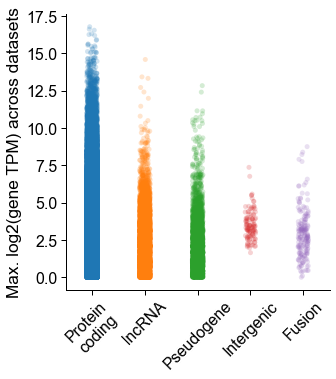

In [182]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
sns.set_context('paper', font_scale=1.8)

order = ['protein_coding', 'lncRNA', 'pseudogene', 'Intergenic', 'Fusion']
labels = ['Protein\ncoding', 'lncRNA', 'Pseudogene', 'Intergenic', 'Fusion']

ax = sns.catplot(df, hue='gene_status', x='gene_status', y='log2_max_tpm',
                 order=order, alpha=0.2)
# ax.set(yscale='log', ylabel='Max. gene TPM across datasets', xlabel='')
ax.set(ylabel='Max. log2(gene TPM) across datasets', xlabel='')
# ax.legend.remove()
# ax.get_legend().set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
ax.tick_params(axis="x", rotation=45)
ax.set_xticklabels(labels)

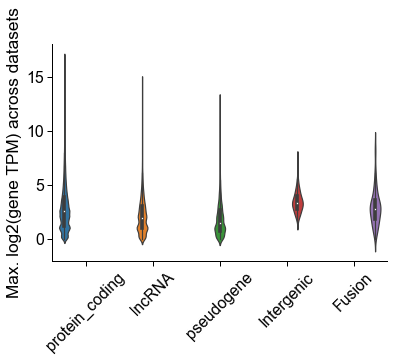

In [187]:
# violin
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
sns.set_context('paper', font_scale=1.8)

order = ['protein_coding', 'lncRNA', 'pseudogene', 'Intergenic', 'Fusion']
labels = ['Protein\ncoding', 'lncRNA', 'Pseudogene', 'Intergenic', 'Fusion']

ax = sns.violinplot(df, hue='gene_status', x='gene_status', y='log2_max_tpm',
                 order=order)
ax.set(ylabel='Max. log2(gene TPM) across datasets', xlabel='')
# ax.legend.remove()
ax.get_legend().set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis="x", rotation=45)

## How many novel readthrough loci do we detect?

In [77]:
df = pd.read_csv(filt_ab, sep='\t')
df, tids = get_tpm_table(df, 
                         how='iso',
                         min_tpm=1,
                         gene_subset=None)
df.reset_index(inplace=True)
df['gid'] = df.annot_transcript_id.str.split('[', expand=True)[0]
ab_df = pd.read_csv(filt_ab, sep='\t')
ab_df['gid'] = ab_df.annot_transcript_id.str.split('[', expand=True)[0]
ab_df = ab_df[['gid', 'gene_novelty']].drop_duplicates()
df = df.merge(ab_df, how='left', on='gid')

Calculating iso TPM values


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2053: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2052: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 228876
# isos >= 1 tpm: 206731
Number of isos reported: 206731


In [80]:
n = len(df.loc[df.gene_novelty=='Fusion'].gid.unique())
print(f'Found {n} fusion loci in human')

Found 79 fusion loci in human


## How many GENCODE genes engage in readthrough transcription?

In [134]:
df = pr.read_gtf(ref_gtf, duplicate_attr=True)

In [135]:
df = df.df
df = df.loc[df.Feature=='transcript']

In [143]:
# is it possible that a not all transcripts from a given gene are called as readthrough? 
temp = df[['gene_id','transcript_id','tag']]
temp['readthrough_transcript'] = temp.tag.str.contains('readthrough_transcript')
temp.drop('tag', axis=1, inplace=True)

gids = temp.loc[temp.readthrough_transcript==True]
temp.loc[(temp.gene_id.isin(gids))&(temp.readthrough_transcript==False)]

# nope
assert len(temp.loc[(temp.gene_id.isin(gids))&(temp.readthrough_transcript==False)]) == 0

In [101]:
rt_df = df.loc[(df.tag.notnull())&(df.tag.str.contains('readthrough_transcript'))]
rt_df = rt_df[['gene_id', 'transcript_id']].drop_duplicates()
rt_df['gid_stable'] = cerberus.get_stable_gid(rt_df, 'gene_id')
n = len(rt_df.gene_id.unique().tolist())
print(f'Gencode v40 has {n} genes w/ annotated readthrough transcription')
n = len(rt_df.transcript_id.unique().tolist())
print(f'Gencode v40 has {n} transcripts w/ annotated readthrough transcription')

Gencode v40 has 981 genes w/ annotated readthrough transcription


In [98]:
rt_df.head()

,gene_id,gid_stable
10466,ENSG00000251503.8,ENSG00000251503
11013,ENSG00000120948.19,ENSG00000120948
17404,ENSG00000285853.1,ENSG00000285853
18782,ENSG00000270136.6,ENSG00000270136
19899,ENSG00000285959.1,ENSG00000285959


## How many transcripts w/ annotated readthrough transcription do we detect?

In [188]:
df, _, _ = get_gtf_info(ver='v40_cerberus', how='iso')
rt_df = df.loc[df.readthrough_transcript==True]
len(rt_df.index)

2075

In [189]:
ab_df = pd.read_csv(filt_ab, sep='\t')
ab_df, tids = get_tpm_table(ab_df, 
                         how='iso',
                         min_tpm=1,
                         gene_subset=None)

Calculating iso TPM values


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2053: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2052: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 228876
# isos >= 1 tpm: 206731
Number of isos reported: 206731


In [190]:
ab_df = ab_df.reset_index()
ab_df.rename({'annot_transcript_id':'tid'}, axis=1, inplace=True)

In [191]:
# % of rt gencode transcripts
n = len(rt_df.index)
n_num = len(ab_df.loc[ab_df.tid.isin(rt_df.tid.tolist())].index)
print('{:.2f}% ({}/{}) of GENCODE v40 readthrough transcripts were observed'.format((n_num/n)*100, n_num, n))

14.02% (291/2075) of GENCODE v40 readthrough transcripts were observed


In [206]:
# % of rt gencode genes
n = len(rt_df.gid_stable.unique().tolist())
n_num = len(ab_df.loc[ab_df.gid.isin(rt_df.gid_stable.tolist())].gid.unique().tolist())
print('{:.2f}% ({}/{}) of GENCODE v40 readthrough transcripts were observed'.format((n_num/n)*100, n_num, n))

32.82% (322/981) of GENCODE v40 readthrough transcripts were observed


## What does the expression of known readthrough loci look like compared to novel?

In [114]:
df, _, _ = get_gtf_info(ver='v40_cerberus', how='iso')
rt_df = df.loc[df.readthrough_transcript==True]
len(rt_df.index)

2075

In [122]:
ab_df = pd.read_csv(filt_ab, sep='\t')
ab_df, tids = get_tpm_table(ab_df, 
                         how='iso',
                         min_tpm=1,
                         gene_subset=None)
ab_df = ab_df.reset_index()
ab_df.rename({'annot_transcript_id':'tid'}, axis=1, inplace=True)
ab_df['readthrough_novelty'] = ''
ab_df.loc[ab_df.tid.isin(rt_df.tid.tolist()), 'readthrough_novelty'] = 'Known'
ab_df['gid'] = ab_df.tid.str.split('[', expand=True)[0]

Calculating iso TPM values


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2053: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2052: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 228876
# isos >= 1 tpm: 206731
Number of isos reported: 206731


In [123]:
df = pd.read_csv(filt_ab, sep='\t')
df['gid'] = df.annot_transcript_id.str.split('[', expand=True)[0]
df = df[['gid', 'gene_novelty']].drop_duplicates()

In [124]:
len(df.loc[df.gene_novelty.str.contains('Fusion')].index)

80

In [125]:
df = df.loc[df.gene_novelty.str.contains('Fusion')]

In [128]:
ab_df.loc[ab_df.gid.isin(df.gid.tolist()), 'readthrough_novelty'] = 'Novel'

In [130]:
ab_df = ab_df.loc[ab_df.readthrough_novelty!='']

In [133]:
ab_df[['tid', 'readthrough_novelty']].groupby('readthrough_novelty').count().reset_index().rename({'tid':'n_transcripts'}, axis=1)

,readthrough_novelty,n_transcripts
0,Known,291
1,Novel,181


In [144]:
datasets = get_datasets('human')
ab_df['max_tpm'] = ab_df[datasets].max(axis=1)
ab_df.drop(datasets, axis=1, inplace=True)

In [147]:
ab_df['log2_max_tpm'] = np.log2(ab_df.max_tpm)
ab_df.head()

,tid,readthrough_novelty,gid,max_tpm,log2_max_tpm
805,"ENSG00000114786[1,1,1]",Known,ENSG00000114786,1.572433,0.652999
806,"ENSG00000114786[1,19,2]",Known,ENSG00000114786,1.597883,0.676162
807,"ENSG00000114786[1,3,1]",Known,ENSG00000114786,3.034030,1.601235
808,"ENSG00000114786[1,5,1]",Known,ENSG00000114786,1.176161,0.234085
1217,"ENSG00000283208[1,1,1]",Known,ENSG00000283208,4.649073,2.216943


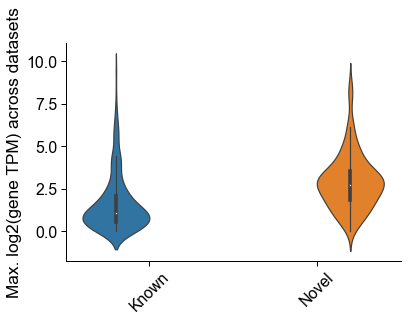

In [154]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
sns.set_context('paper', font_scale=1.8)

order = ['Known', 'Novel']

ax = sns.violinplot(ab_df, hue='readthrough_novelty', x='readthrough_novelty', y='log2_max_tpm',
                 order=order, alpha=0.2)
# ax.set(yscale='log', ylabel='Max. gene TPM across datasets', xlabel='')
ax.set(ylabel='Max. log2(gene TPM) across datasets', xlabel='')
# ax.legend.remove()
ax.get_legend().set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis="x", rotation=45)

In [156]:
ab_df.head()
ab_df.to_csv('human_known_novel_readthrough.tsv', sep='\t', index=False)

## What does transcriptional diversity look like for known and novel readthrough guys?

In [157]:
df = pd.read_csv('human_known_novel_readthrough.tsv', sep='\t')
df.head()

,tid,readthrough_novelty,gid,max_tpm,log2_max_tpm
0,"ENSG00000114786[1,1,1]",Known,ENSG00000114786,1.572433,0.652999
1,"ENSG00000114786[1,19,2]",Known,ENSG00000114786,1.597883,0.676162
2,"ENSG00000114786[1,3,1]",Known,ENSG00000114786,3.034030,1.601235
3,"ENSG00000114786[1,5,1]",Known,ENSG00000114786,1.176161,0.234085
4,"ENSG00000283208[1,1,1]",Known,ENSG00000283208,4.649073,2.216943


In [161]:
tids = df.tid.tolist()

In [158]:
ca = cerberus.read(cerberus_h5)

In [165]:
df = ca.get_subset_triplets(tids, source='obs_readthrough')


,gene_id,n_iso,n_tss,n_ic,n_tes,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,source
0,ENSG00000011052,3,1,3,1,3.000000,0.200000,0.200000,0.600000,splicing,obs_readthrough
1,ENSG00000064489,3,1,3,1,3.000000,0.200000,0.200000,0.600000,splicing,obs_readthrough
2,ENSG00000103426,1,1,1,1,1.000000,0.333333,0.333333,0.333333,simple,obs_readthrough
3,ENSG00000108825,4,2,4,1,2.666667,0.352941,0.176471,0.470588,mixed,obs_readthrough
4,ENSG00000111780,1,1,1,1,1.000000,0.333333,0.333333,0.333333,simple,obs_readthrough
